In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [41]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 11))

In [42]:
rand_sub_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255])

In [43]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [44]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [45]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [46]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [47]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

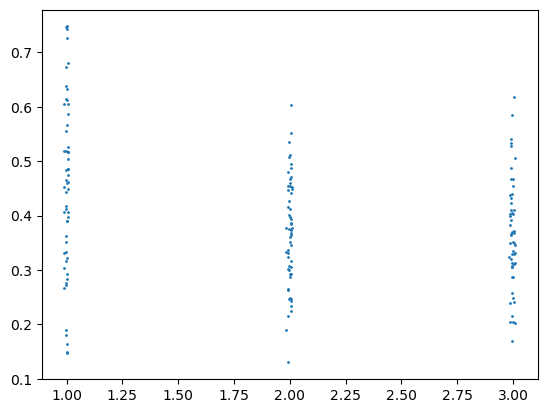

In [48]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [49]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [52]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [53]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(166, 3)


In [54]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [55]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [ ]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.03it/s]


Loss: 2594.76505997777
Average Loss: 0.35505816365322523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.87it/s]


Loss: 2593.3175214231014
Average Loss: 0.354860087769992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.20it/s]


Loss: 2592.588726848364
Average Loss: 0.3547603621850525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.33it/s]


Loss: 2592.137541383505
Average Loss: 0.3546986236156958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.30it/s]


Loss: 2591.9330665171146
Average Loss: 0.3546706440225937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.52it/s]


Loss: 2592.041515380144
Average Loss: 0.3546854837684926
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.89it/s]


Loss: 2591.5875037014484
Average Loss: 0.35462335847036786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.19it/s]


Loss: 2591.5658279061317
Average Loss: 0.35462039243378923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.35it/s]


Loss: 2591.1375695466995
Average Loss: 0.35456179112571146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.85it/s]


Loss: 1345.0277909305878
Average Loss: 0.18404868513007497
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▉                                                                                                                                                           | 134/7308 [00:03<00:53, 133.01it/s]

X_batch: 
torch.Size([128, 166])
tensor([[0.0605, 0.0210, 0.0293,  ..., 0.0541, 0.0303, 0.0307],
        [0.2615, 0.1413, 0.1314,  ..., 0.2229, 0.0640, 0.1118],
        [0.3615, 0.1324, 0.1059,  ..., 0.3111, 0.0872, 0.1828],
        ...,
        [0.4510, 0.2495, 0.1724,  ..., 0.3938, 0.1423, 0.2656],
        [0.4644, 0.3341, 0.2501,  ..., 0.5914, 0.1851, 0.2984],
        [0.0824, 0.0190, 0.0327,  ..., 0.0880, 0.0266, 0.0304]])
X_pred: 
torch.Size([128, 166])
tensor([[0.3003, 0.0956, 0.0337,  ..., 0.2997, 0.0340, 0.0967],
        [0.3201, 0.1327, 0.0741,  ..., 0.3162, 0.0764, 0.1367],
        [0.3375, 0.1557, 0.0965,  ..., 0.3319, 0.0997, 0.1613],
        ...,
        [0.4137, 0.2372, 0.1665,  ..., 0.4035, 0.1732, 0.2469],
        [0.4804, 0.3080, 0.2262,  ..., 0.4662, 0.2352, 0.3210],
        [0.3083, 0.1024, 0.0387,  ..., 0.3074, 0.0392, 0.1038]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.78it/s]


Loss: 423.32245940202847
Average Loss: 0.05792589756459065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.04it/s]


Loss: 419.136440301314
Average Loss: 0.05735309801605282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.43it/s]


Loss: 417.81683530425653
Average Loss: 0.05717252809308382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.28it/s]


Loss: 417.2284437669441
Average Loss: 0.057092014746434605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.36it/s]


Loss: 417.0336142387241
Average Loss: 0.05706535498614178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.33it/s]


Loss: 417.0136387459934
Average Loss: 0.05706262161275224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.25it/s]


Loss: 415.7965865517035
Average Loss: 0.05689608464035352
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 101.56it/s]


Loss: 415.8149788400624
Average Loss: 0.05689860137384543
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.29it/s]


Loss: 415.8026080848649
Average Loss: 0.056896908604934994
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.76it/s]


Loss: 415.25138656562194
Average Loss: 0.056821481467654894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.13it/s]


Loss: 415.2342013011221
Average Loss: 0.05681912989889465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.80it/s]


Loss: 414.4145864422899
Average Loss: 0.0567069767983429
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.59it/s]


Loss: 414.538558624452
Average Loss: 0.05672394069847454
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.34it/s]


Loss: 414.08838473423384
Average Loss: 0.05666234054929308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.33it/s]


Loss: 413.76328913867474
Average Loss: 0.056617855656633104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.54it/s]


Loss: 413.47119670081884
Average Loss: 0.056577886795404875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.00it/s]


Loss: 412.7041427860968
Average Loss: 0.056472925942268305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.05it/s]


Loss: 412.5669650034979
Average Loss: 0.05645415503605609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.01it/s]


Loss: 411.63046774151735
Average Loss: 0.0563260081748108
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.69it/s]


Loss: 411.4548935003113
Average Loss: 0.05630198323759049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.36it/s]


Loss: 411.037732466124
Average Loss: 0.05624490044692446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.76it/s]


Loss: 410.89874162734486
Average Loss: 0.05622588144873356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.10it/s]


Loss: 410.43570841429755
Average Loss: 0.05616252167683327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.93it/s]


Loss: 410.29821186652407
Average Loss: 0.05614370715196006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.10it/s]


Loss: 409.5274121812545
Average Loss: 0.056038233741277296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.17it/s]


Loss: 409.54679211904295
Average Loss: 0.05604088562110604
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.58it/s]


Loss: 408.5659413712565
Average Loss: 0.055906669591031265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.61it/s]


Loss: 408.57592065492645
Average Loss: 0.055908035119721734
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.97it/s]


Loss: 407.80367248505354
Average Loss: 0.05580236350370191
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.19it/s]


Loss: 407.98942826432176
Average Loss: 0.05582778164536423
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.18it/s]


Loss: 407.44838891061954
Average Loss: 0.05575374779838801
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.47it/s]


Loss: 407.2513910906855
Average Loss: 0.05572679133698488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.32it/s]


Loss: 406.8570545162074
Average Loss: 0.05567283176193315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.02it/s]


Loss: 406.5162718030624
Average Loss: 0.055626200301459004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.34it/s]


Loss: 406.4177912219893
Average Loss: 0.055612724578816275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.23it/s]


Loss: 406.761777845677
Average Loss: 0.055659794450694716
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.63it/s]


Loss: 405.9623868111521
Average Loss: 0.055550408704317475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.05it/s]


Loss: 405.8732057143934
Average Loss: 0.05553820548910692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.55it/s]


Loss: 405.8879519253969
Average Loss: 0.05554022330670456
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.12it/s]


Loss: 405.7198327695951
Average Loss: 0.05551721849611318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.93it/s]


Loss: 405.08315503573976
Average Loss: 0.055430097842876266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.63it/s]


Loss: 405.35263548162766
Average Loss: 0.055466972561799076
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.21it/s]


Loss: 404.7884754675906
Average Loss: 0.05538977496819795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.51it/s]


Loss: 404.8491548052989
Average Loss: 0.05539807810691008
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.04it/s]


Loss: 404.51351428055204
Average Loss: 0.05535215028469513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.38it/s]


Loss: 404.40561185451224
Average Loss: 0.05533738531123594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.91it/s]


Loss: 404.2461706791073
Average Loss: 0.05531556796375305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.91it/s]


Loss: 403.96748038963415
Average Loss: 0.05527743300350768
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.54it/s]


Loss: 403.87840162427165
Average Loss: 0.05526524379095124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.84it/s]


Loss: 403.8171765699517
Average Loss: 0.055256865978373246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.40it/s]


Loss: 403.53124571288936
Average Loss: 0.05521774024533242
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.04it/s]


Loss: 403.67846919200383
Average Loss: 0.055237885767926084
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.89it/s]


Loss: 403.36548391659744
Average Loss: 0.05519505800719724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.08it/s]


Loss: 403.4385103774257
Average Loss: 0.055205050681092736
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.75it/s]


Loss: 403.0070914106909
Average Loss: 0.055146016887067724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.96it/s]


Loss: 403.10502219432965
Average Loss: 0.05515941737743974
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.50it/s]


Loss: 402.73243687534705
Average Loss: 0.05510843416466161
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.11it/s]


Loss: 402.9142953653354
Average Loss: 0.05513331901550841
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.33it/s]


Loss: 402.9010636040475
Average Loss: 0.05513150842967262
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.30it/s]


Loss: 402.71918863547035
Average Loss: 0.05510662132395599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.54it/s]


Loss: 402.5314518455416
Average Loss: 0.05508093210803799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.38it/s]


Loss: 402.4728939284105
Average Loss: 0.05507291925676115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.17it/s]


Loss: 402.56960273790173
Average Loss: 0.055086152536658696
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.39it/s]


Loss: 402.26394468639046
Average Loss: 0.05504432740645737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.90it/s]


Loss: 402.1141390744597
Average Loss: 0.055023828554250094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.07it/s]


Loss: 402.13046233239584
Average Loss: 0.05502606216918388
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.24it/s]


Loss: 402.24951776256785
Average Loss: 0.05504235327895017
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.01it/s]


Loss: 402.11186907673255
Average Loss: 0.05502351793606083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.83it/s]


Loss: 402.11556399124674
Average Loss: 0.05502402353465336
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.39it/s]


Loss: 401.85157793131657
Average Loss: 0.05498790064741606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.04it/s]


Loss: 402.06023316737264
Average Loss: 0.0550164522670187
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.31it/s]


Loss: 401.78190261079
Average Loss: 0.054978366531306784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.85it/s]


Loss: 401.92691806633957
Average Loss: 0.05499820991602895
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.73it/s]


Loss: 401.65748668741435
Average Loss: 0.05496134191124991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 119.88it/s]


Loss: 401.65889364108443
Average Loss: 0.054961534433645924
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.39it/s]


Loss: 401.53681763028726
Average Loss: 0.054944829998670945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.73it/s]


Loss: 401.4613209401723
Average Loss: 0.054934499307631675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.57it/s]


Loss: 401.51897734589875
Average Loss: 0.05494238879938407
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.07it/s]


Loss: 401.348998647416
Average Loss: 0.05491912953577121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.66it/s]


Loss: 401.6078210985288
Average Loss: 0.05495454585365747
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.05it/s]


Loss: 401.20758513663895
Average Loss: 0.05489977902800205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.67it/s]


Loss: 401.45754705532454
Average Loss: 0.054933982903027444
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.54it/s]


Loss: 401.3304757606238
Average Loss: 0.05491659493166719
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.64it/s]


Loss: 401.26094865449704
Average Loss: 0.05490708109667447
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.31it/s]


Loss: 401.1369667823892
Average Loss: 0.05489011587060608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.69it/s]


Loss: 401.3945278385654
Average Loss: 0.054925359583821214
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.74it/s]


Loss: 400.9577107185032
Average Loss: 0.05486558712623197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.51it/s]


Loss: 400.88433872535825
Average Loss: 0.054855547170957614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.49it/s]


Loss: 401.0152365611866
Average Loss: 0.054873458752214915
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.53it/s]


Loss: 400.9500848450698
Average Loss: 0.054864543629593567
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.16it/s]


Loss: 400.8073771363124
Average Loss: 0.05484501602850471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.47it/s]


Loss: 401.02724036341533
Average Loss: 0.05487510130862279
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.15it/s]


Loss: 400.90224878583103
Average Loss: 0.05485799791814874
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.51it/s]


Loss: 400.70346832019277
Average Loss: 0.054830797526025286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.82it/s]


Loss: 400.8563273756299
Average Loss: 0.05485171420027777
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.45it/s]


Loss: 400.65862659784034
Average Loss: 0.054824661548691894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.14it/s]


Loss: 400.7448871540837
Average Loss: 0.0548364651278166
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.31it/s]


Loss: 400.6181191848591
Average Loss: 0.05481911866240546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.28it/s]


Loss: 400.5808690811973
Average Loss: 0.054814021494416706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.85it/s]


Loss: 400.61416759504937
Average Loss: 0.054818577941303966
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.64it/s]


Loss: 400.4813429939095
Average Loss: 0.0548004027085262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.22it/s]


Loss: 400.4317867581267
Average Loss: 0.05479362161441252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.57it/s]


Loss: 400.463351001963
Average Loss: 0.05479794075013178
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.88it/s]


Loss: 400.55744968238287
Average Loss: 0.05481081686951052
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.79it/s]


Loss: 400.4689978121314
Average Loss: 0.054798713438988976
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.62it/s]


Loss: 400.27920243749395
Average Loss: 0.054772742533866166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.83it/s]


Loss: 400.4246735968627
Average Loss: 0.05479264827543277
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.04it/s]


Loss: 400.33766296342947
Average Loss: 0.05478074205848789
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.88it/s]


Loss: 400.3068545369897
Average Loss: 0.0547765263460577
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.47it/s]


Loss: 400.1997144499328
Average Loss: 0.054761865688277615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.24it/s]


Loss: 400.21875667828135
Average Loss: 0.054764471357181356
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.31it/s]


Loss: 400.11013078084216
Average Loss: 0.05474960738654107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.46it/s]


Loss: 400.25765327038243
Average Loss: 0.05476979382462814
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.87it/s]


Loss: 400.0808190566022
Average Loss: 0.05474559647736757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.13it/s]


Loss: 400.2189070552122
Average Loss: 0.054764491934210756
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.53it/s]


Loss: 400.19428732036613
Average Loss: 0.054761123059710745
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.31it/s]


Loss: 400.1464608202223
Average Loss: 0.05475457865629752
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.90it/s]


Loss: 399.9990214884747
Average Loss: 0.054734403597218755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.58it/s]


Loss: 400.0936958307866
Average Loss: 0.054747358488066035
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.47it/s]


Loss: 399.96233060769737
Average Loss: 0.054729382951244854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:47<00:00, 67.77it/s]


Loss: 399.9863603913691
Average Loss: 0.05473267109898318
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 100.08it/s]


Loss: 400.0191733741667
Average Loss: 0.05473716110757618
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 78.88it/s]


Loss: 399.8969180462882
Average Loss: 0.05472043213550742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [02:08<00:00, 57.09it/s]


Loss: 399.9133202407975
Average Loss: 0.054722676551833264
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:33<00:00, 78.04it/s]


Loss: 399.9501064843498
Average Loss: 0.05472771024690063
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 93.21it/s]


Loss: 399.89332517352886
Average Loss: 0.05471994049993553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 104.43it/s]


Loss: 399.9174234333914
Average Loss: 0.05472323801770544
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:35<00:00, 76.63it/s]


Loss: 399.80927114211954
Average Loss: 0.05470843885360147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:38<00:00, 74.11it/s]


Loss: 399.7605326336343
Average Loss: 0.05470176965430135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:42<00:00, 71.26it/s]


Loss: 399.7904650787823
Average Loss: 0.05470586550065439
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [02:02<00:00, 59.60it/s]


Loss: 399.7300372631289
Average Loss: 0.05469759677930062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:30<00:00, 80.89it/s]


Loss: 399.82736842660233
Average Loss: 0.05471091521984159
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:37<00:00, 75.32it/s]


Loss: 399.70954770524986
Average Loss: 0.05469479306311575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.51it/s]


Loss: 399.6179495677352
Average Loss: 0.054682259108885495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.11it/s]


Loss: 399.72905267821625
Average Loss: 0.054697462052301075
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.49it/s]


Loss: 399.6893465165049
Average Loss: 0.05469202880630882
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.13it/s]


Loss: 399.6932729266118
Average Loss: 0.05469256608191185
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 104.49it/s]


Loss: 399.6717467857525
Average Loss: 0.05468962052350198
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.95it/s]


Loss: 399.7943563570734
Average Loss: 0.054706397968948196
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 93.28it/s]


Loss: 399.67210768931545
Average Loss: 0.05468966990822598
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.43it/s]


Loss: 399.56496138335206
Average Loss: 0.05467500839947346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.86it/s]


Loss: 399.56994203524664
Average Loss: 0.05467568993366812
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 78.79it/s]


Loss: 399.54990752390586
Average Loss: 0.05467294848438777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:25<00:00, 85.43it/s]


Loss: 399.6133341763634
Average Loss: 0.05468162755560529
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 97.89it/s]


Loss: 399.6497159395367
Average Loss: 0.05468660590305647
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 79.25it/s]


Loss: 399.57560718711466
Average Loss: 0.054676465132336434
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:25<00:00, 85.77it/s]


Loss: 399.53251776401885
Average Loss: 0.05467056893322644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.03it/s]


Loss: 399.46264652186073
Average Loss: 0.05466100800791745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 97.18it/s]


Loss: 399.4366940225009
Average Loss: 0.05465745676279432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 92.28it/s]


Loss: 399.5461872534361
Average Loss: 0.05467243941617899
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.68it/s]


Loss: 399.589611091651
Average Loss: 0.05467838137543118
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:22<00:00, 88.78it/s]


Loss: 399.36327454145066
Average Loss: 0.05464741030944864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.51it/s]


Loss: 399.45675841346383
Average Loss: 0.05466020230069291
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 97.40it/s]


Loss: 399.51280393544585
Average Loss: 0.054667871365003534
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 104.64it/s]


Loss: 399.42187217180617
Average Loss: 0.054655428594937897
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.05it/s]


Loss: 399.3989649810828
Average Loss: 0.05465229405871413
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:26<00:00, 84.93it/s]


Loss: 399.444456738187
Average Loss: 0.054658518984426245
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [02:07<00:00, 57.38it/s]


Loss: 399.4984829239547
Average Loss: 0.05466591173015253
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:52<00:00, 65.20it/s]


Loss: 399.4068934516981
Average Loss: 0.054653378961644516
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.62it/s]


Loss: 399.54135078098625
Average Loss: 0.054671777610972395
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:39<00:00, 73.52it/s]


Loss: 399.3251188744325
Average Loss: 0.05464218922748119
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:52<00:00, 65.14it/s]


Loss: 399.2911477976013
Average Loss: 0.05463754074953493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:42<00:00, 71.44it/s]


Loss: 399.38472057529725
Average Loss: 0.05465034490630778
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.64it/s]


Loss: 399.33532183640637
Average Loss: 0.05464358536349293
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.21it/s]


Loss: 399.3486614297144
Average Loss: 0.05464541070466809
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.81it/s]


Loss: 399.3747167061083
Average Loss: 0.054648976013424784
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.82it/s]


Loss: 399.3919802075252
Average Loss: 0.0546513382878387
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.15it/s]


Loss: 399.25711839739233
Average Loss: 0.054632884290830915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:35<00:00, 76.45it/s]


Loss: 399.27838102774695
Average Loss: 0.05463579379142679
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:42<00:00, 71.48it/s]


Loss: 399.1668658142444
Average Loss: 0.0546205344573405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:28<00:00, 82.99it/s]


Loss: 399.17583481408656
Average Loss: 0.05462176174248585
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 91.77it/s]


Loss: 399.285741311498
Average Loss: 0.054636800945744114
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.37it/s]


Loss: 399.3201194561552
Average Loss: 0.05464150512536333
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [02:24<00:00, 50.64it/s]


Loss: 399.18622709810734
Average Loss: 0.05462318378463428
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 101.79it/s]


Loss: 399.23364124493673
Average Loss: 0.054629671763127635
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.04it/s]


Loss: 399.1188313800376
Average Loss: 0.054613961600990364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.02it/s]


Loss: 399.1831335411407
Average Loss: 0.05462276047360984
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 93.78it/s]


Loss: 399.10929297911935
Average Loss: 0.054612656401083655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:48<00:00, 67.30it/s]


Loss: 399.2534971355926
Average Loss: 0.05463238877060654
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 79.01it/s]


Loss: 399.2892672272865
Average Loss: 0.054637283419168924
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:29<00:00, 82.00it/s]


Loss: 399.05603717826307
Average Loss: 0.05460536907201191
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:52<00:00, 65.07it/s]


Loss: 399.2392908972688
Average Loss: 0.05463044484089612
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.51it/s]


Loss: 399.03724967013113
Average Loss: 0.054602798258091285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.40it/s]


Loss: 399.04863662994467
Average Loss: 0.05460435640803841
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.12it/s]


Loss: 399.1036402392201
Average Loss: 0.05461188290082377
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:22<00:00, 88.24it/s]


Loss: 399.119126125006
Average Loss: 0.054614001932814175
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.99it/s]


Loss: 399.036625594832
Average Loss: 0.05460271286190914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.58it/s]


Loss: 399.0937052250374
Average Loss: 0.05461052342980807
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 91.96it/s]


Loss: 399.22556031146087
Average Loss: 0.05462856599773685
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.17it/s]


Loss: 399.17757907742634
Average Loss: 0.05462200042110377
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.02it/s]


Loss: 398.9795228308067
Average Loss: 0.054594899128462875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.96it/s]


Loss: 399.039851764217
Average Loss: 0.05460315431913205
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.81it/s]


Loss: 399.18502845452167
Average Loss: 0.05462301976662858
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.22it/s]


Loss: 399.0654872923624
Average Loss: 0.05460666219107312
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.07it/s]


Loss: 399.03576430445537
Average Loss: 0.05460259500608311
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.70it/s]


Loss: 399.06981721543707
Average Loss: 0.05460725468191531
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.96it/s]


Loss: 398.9642905141227
Average Loss: 0.054592814793941256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.95it/s]


Loss: 399.04582232725807
Average Loss: 0.05460397130914861
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.01it/s]


Loss: 398.9773208235856
Average Loss: 0.05459459781384587
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.67it/s]


Loss: 398.92587658250704
Average Loss: 0.054587558371990565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.88it/s]


Loss: 398.94596596318297
Average Loss: 0.05459030732939012
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.91it/s]


Loss: 399.01634883205406
Average Loss: 0.05459993826382787
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.18it/s]


Loss: 399.05086685647257
Average Loss: 0.05460466158408218
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.48it/s]


Loss: 398.94072917778976
Average Loss: 0.054589590746824
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.97it/s]


Loss: 398.9862183770165
Average Loss: 0.05459581532252552
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.61it/s]


Loss: 399.0511309527792
Average Loss: 0.05460469772205517
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.91it/s]


Loss: 398.86772178066894
Average Loss: 0.05457960068153653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.25it/s]


Loss: 398.9578239014372
Average Loss: 0.05459192992630504
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.30it/s]


Loss: 398.96019144239835
Average Loss: 0.054592253891953796
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.18it/s]


Loss: 398.93836807855405
Average Loss: 0.05458926766263739
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.23it/s]


Loss: 398.96910023200326
Average Loss: 0.054593472938150416
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 99.21it/s]


Loss: 398.92469124752097
Average Loss: 0.05458739617508497
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.53it/s]


Loss: 398.86088258051313
Average Loss: 0.05457866483039315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.31it/s]


Loss: 398.81314445473254
Average Loss: 0.054572132519804674
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.32it/s]


Loss: 398.8616615405772
Average Loss: 0.05457877142044023
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.78it/s]


Loss: 398.8243268742226
Average Loss: 0.05457366268120178
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.70it/s]


Loss: 398.8112297952175
Average Loss: 0.054571870524797145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.92it/s]


Loss: 398.88593968353234
Average Loss: 0.05458209355275483
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.60it/s]


Loss: 398.8694548283238
Average Loss: 0.05457983782544113
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.01it/s]


Loss: 398.8577316743322
Average Loss: 0.0545782336719119
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.85it/s]


Loss: 398.93154413439333
Average Loss: 0.0545883338990686
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.99it/s]


Loss: 398.75032909819856
Average Loss: 0.05456353709608629
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.45it/s]


Loss: 398.8358259217348
Average Loss: 0.054575236168819756
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.73it/s]


Loss: 398.78718905034475
Average Loss: 0.054568580877168135
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.11it/s]


Loss: 398.8306926426012
Average Loss: 0.05457453374967176
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 98.09it/s]


Loss: 398.8759904182516
Average Loss: 0.05458073213167099
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.22it/s]


Loss: 398.7363984333351
Average Loss: 0.0545616308748406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.01it/s]


Loss: 398.743764315499
Average Loss: 0.05456263879522427
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.00it/s]


Loss: 398.7494981477503
Average Loss: 0.054563423391865117
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.35it/s]


Loss: 398.78127429494634
Average Loss: 0.05456777152366535
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.11it/s]


Loss: 398.9610898983665
Average Loss: 0.05459237683338348
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.65it/s]


Loss: 398.8178165226709
Average Loss: 0.05457277182849903
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 98.62it/s]


Loss: 398.73032634006813
Average Loss: 0.05456079999179914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.24it/s]


Loss: 398.9339711663779
Average Loss: 0.05458866600525149
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.24it/s]


Loss: 398.7912719894666
Average Loss: 0.05456913957162926
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.28it/s]


Loss: 398.7878888528794
Average Loss: 0.054568676635588315
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:24<00:00, 86.20it/s]


Loss: 398.7472727287095
Average Loss: 0.054563118873660305
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.90it/s]


Loss: 398.7593728103675
Average Loss: 0.054564774604593254
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.42it/s]


Loss: 398.7191645388957
Average Loss: 0.05455927265173723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:25<00:00, 85.23it/s]


Loss: 398.73267126549035
Average Loss: 0.054561120862820243
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.52it/s]


Loss: 398.82798406737857
Average Loss: 0.05457416311814157
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.22it/s]


Loss: 398.71256838715635
Average Loss: 0.05455837005845051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.09it/s]


Loss: 398.6459418120794
Average Loss: 0.054549253121521535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.33it/s]


Loss: 398.69418931310065
Average Loss: 0.054555855133155536
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.20it/s]


Loss: 398.72266417741776
Average Loss: 0.05455975152947698
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.56it/s]


Loss: 398.63243440631777
Average Loss: 0.0545474048175038
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:28<00:00, 82.70it/s]


Loss: 398.62562717171386
Average Loss: 0.05454647334040967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.46it/s]


Loss: 398.6814465348143
Average Loss: 0.054554111457965834
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 146.03it/s]


Loss: 398.73499038652517
Average Loss: 0.05456143820286332
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 123.88it/s]


Loss: 398.7234127607662
Average Loss: 0.05455985396288536
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.69it/s]


Loss: 398.67912496067584
Average Loss: 0.05455379378224902
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.15it/s]


Loss: 398.77795255207457
Average Loss: 0.05456731698851595
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.46it/s]


Loss: 398.66659860359505
Average Loss: 0.05455207972134579
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.69it/s]


Loss: 398.771812194027
Average Loss: 0.05456647676437151
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.73it/s]


Loss: 398.7103547679726
Average Loss: 0.054558067154894994
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.77it/s]


Loss: 398.75454382621683
Average Loss: 0.05456411382405813
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.65it/s]


Loss: 398.5816019179765
Average Loss: 0.054540449085656334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.70it/s]


Loss: 398.593189046951
Average Loss: 0.054542034626019566
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.58it/s]


Loss: 398.63562555005774
Average Loss: 0.054547841481945504
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.71it/s]


Loss: 398.6286718749907
Average Loss: 0.05454688996647382
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.34it/s]


Loss: 398.5554239479825
Average Loss: 0.054536866987956005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [04:59<00:00, 24.39it/s]


Loss: 398.73207000573166
Average Loss: 0.05456103858863323
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.06it/s]


Loss: 398.67642341321334
Average Loss: 0.05455342411237183
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.74it/s]


Loss: 398.61849633185193
Average Loss: 0.05454549758235522
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.96it/s]


Loss: 398.7443730153609
Average Loss: 0.05456272208748781
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.68it/s]


Loss: 398.7050543958321
Average Loss: 0.05455734187135086
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.31it/s]


Loss: 398.72219733614475
Average Loss: 0.054559687648624074
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.23it/s]


Loss: 398.6893698419444
Average Loss: 0.05455519565434379
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.63it/s]


Loss: 398.54247879516333
Average Loss: 0.054535095620575166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.06it/s]


Loss: 398.53447104617953
Average Loss: 0.054533999869482694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 5732/7308 [00:29<00:07, 219.14it/s]

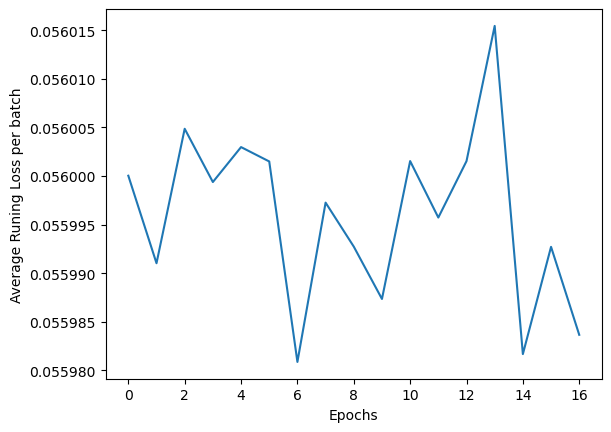

In [39]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [40]:
torch.save(final_model, 'model_100206_11g_01.pt')